In [1]:
#Mounting Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
#Import data from google drive
data = pd.read_csv('/content/drive/MyDrive/ML_Datasets/loan.csv',skiprows=1)
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,NaN,NaN,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
42534,NaN,NaN,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
42535,NaN,NaN,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 460296150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **Data Prepration and Cleaning**

---



In [4]:
#selection of necessary columns for our analysis
df = data.filter(['loan_amnt','int_rate','emp_length','home_ownership',
                    'annual_inc','purpose','addr_state','dti','loan_status'])
df.dtypes

loan_amnt         float64
int_rate           object
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
addr_state         object
dti               float64
loan_status        object
dtype: object

In [5]:
#changing int_rate to float
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0

In [6]:
## dropping the null rows since we have sufficient amount of data and there is no need to fill the null values.
df.dropna(axis=0, inplace=True)

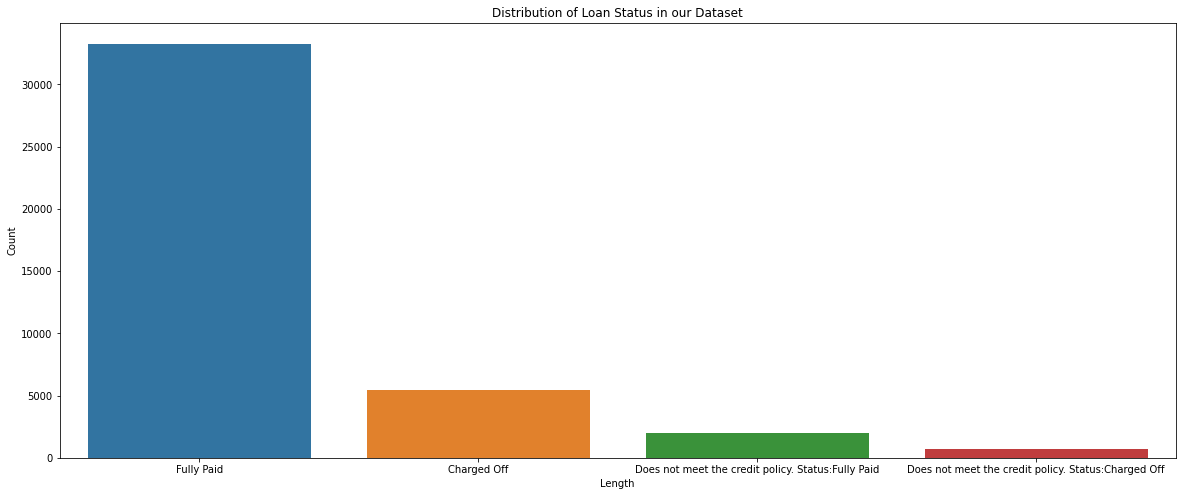

In [7]:
m =df['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()

In [8]:
df = df.replace({'loan_status':{'Charged Off':'Default'
                                ,'Does not meet the credit policy. Status:Charged Off':'Default'
                                ,'Does not meet the credit policy. Status:Fully Paid':'Fully Paid'}})
df['loan_status'].value_counts()

Fully Paid    35233
Default        6186
Name: loan_status, dtype: int64

In [9]:
df

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,loan_status
0,5000.0,0.1065,10+ years,RENT,24000.0,credit_card,AZ,27.65,Fully Paid
1,2500.0,0.1527,< 1 year,RENT,30000.0,car,GA,1.00,Default
2,2400.0,0.1596,10+ years,RENT,12252.0,small_business,IL,8.72,Fully Paid
3,10000.0,0.1349,10+ years,RENT,49200.0,other,CA,20.00,Fully Paid
4,3000.0,0.1269,1 year,RENT,80000.0,other,OR,17.94,Fully Paid
...,...,...,...,...,...,...,...,...,...
42530,6500.0,0.0964,< 1 year,RENT,20000.0,other,CT,10.00,Default
42531,3500.0,0.1028,< 1 year,RENT,180000.0,other,NY,10.00,Fully Paid
42532,1000.0,0.0964,< 1 year,RENT,12000.0,other,MA,10.00,Fully Paid
42533,2525.0,0.0933,< 1 year,RENT,110000.0,other,NY,10.00,Fully Paid


# **Transformation**


In [10]:
X = df.iloc [:, :-1].values
y = df.iloc [:, -1].values

X

array([[5000.0, 0.1065, '10+ years', ..., 'credit_card', 'AZ', 27.65],
       [2500.0, 0.1527, '< 1 year', ..., 'car', 'GA', 1.0],
       [2400.0, 0.15960000000000002, '10+ years', ..., 'small_business',
        'IL', 8.72],
       ...,
       [1000.0, 0.0964, '< 1 year', ..., 'other', 'MA', 10.0],
       [2525.0, 0.0933, '< 1 year', ..., 'other', 'NY', 10.0],
       [5000.0, 0.0775, '10+ years', ..., 'other', 'CT', 8.81]],
      dtype=object)

In [11]:
y

array(['Fully Paid', 'Default', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 0, 1, ..., 1, 1, 1])

In [13]:
X[:, 2] = le.fit_transform(X[:, 2])
X[:, 3] = le.fit_transform(X[:, 3])
X[:, 5] = le.fit_transform(X[:, 5])
X[:, 6] = le.fit_transform(X[:, 6])

X

array([[5000.0, 0.1065, 1, ..., 1, 3, 27.65],
       [2500.0, 0.1527, 10, ..., 0, 10, 1.0],
       [2400.0, 0.15960000000000002, 1, ..., 11, 14, 8.72],
       ...,
       [1000.0, 0.0964, 10, ..., 9, 19, 10.0],
       [2525.0, 0.0933, 10, ..., 9, 33, 10.0],
       [5000.0, 0.0775, 1, ..., 9, 6, 8.81]], dtype=object)

In [14]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 17)

In [15]:
#standarization of the parameters
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [18]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units= 20, activation='relu'))
ann.add(tf.keras.layers.Dense(units= 40, activation= 'relu'))
ann.add(tf.keras.layers.Dense(units= 80, activation= 'relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(loss = 'binary_crossentropy', 
                      optimizer = 'adam', 
                      metrics = ['accuracy'])

In [19]:
res=ann.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
1036/1036 [==============================] - 3s 2ms/step - loss: 0.4099 - accuracy: 0.8500 - val_loss: 0.3980 - val_accuracy: 0.8520
Epoch 2/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3992 - accuracy: 0.8503 - val_loss: 0.3970 - val_accuracy: 0.8520
Epoch 3/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3976 - accuracy: 0.8503 - val_loss: 0.3966 - val_accuracy: 0.8520
Epoch 4/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3962 - accuracy: 0.8503 - val_loss: 0.3945 - val_accuracy: 0.8519
Epoch 5/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3956 - accuracy: 0.8503 - val_loss: 0.3980 - val_accuracy: 0.8519
Epoch 6/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3948 - accuracy: 0.8504 - val_loss: 0.3945 - val_accuracy: 0.8520
Epoch 7/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3944 - accuracy: 0.8506 - val_loss: 0.3951 - val_accuracy:

In [20]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.title('Accuracy score evolution during trainig')
    plt.legend()


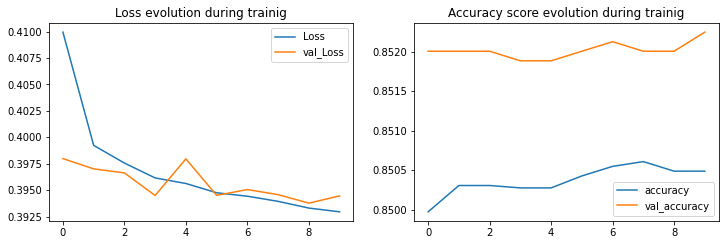

In [21]:
plot_learning_evolution(res)

In [22]:
def evaluate_nn(true, pred, train):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [23]:
y_train_pred = ann.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), True)

Train Result:
Accuracy Score: 85.06%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     1.000000      0.850566  0.850611      0.925283      0.872935
recall        0.002016      1.000000  0.850611      0.501008      0.850611
f1-score      0.004024      0.919250  0.850611      0.461637      0.782249
support    4960.000000  28175.000000  0.850611  33135.000000  33135.000000
_______________________________________________
Confusion Matrix: 
 [[   10  4950]
 [    0 28175]]



In [24]:
y_test_pred = ann.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), False)

Test Result:
Accuracy Score: 85.22%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.666667     0.852380  0.852245     0.759523      0.824895
recall        0.003263     0.999717  0.852245     0.501490      0.852245
f1-score      0.006494     0.920188  0.852245     0.463341      0.784965
support    1226.000000  7058.000000  0.852245  8284.000000   8284.000000
_______________________________________________
Confusion Matrix: 
 [[   4 1222]
 [   2 7056]]



In [25]:
X[5869]

array([3100.0, 0.0751, 5, 0, 32000.0, 1, 33, 17.55], dtype=object)

In [26]:
print(ann.predict(sc.transform([[3100.0, 0.0751, 5, 0, 32000.0, 1, 33, 17.55]])) > 0.5)

[[ True]]


# **Balancing Dataset**
Creating a balancing dataset and feed it to the network

In [ ]:
dfDefault = df[df['loan_status'] == 'Default']
dfFullyPaid = df[df['loan_status'] == 'Fully Paid'].sample(n=len(dfDefault), random_state=17) 
dfDefault

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,loan_status
1,2500.0,0.1527,< 1 year,RENT,30000.0,car,GA,1.00,Default
8,5600.0,0.2128,4 years,OWN,40000.0,small_business,CA,5.55,Default
9,5375.0,0.1269,< 1 year,RENT,15000.0,other,TX,18.08,Default
12,9000.0,0.1349,< 1 year,RENT,30000.0,debt_consolidation,VA,10.08,Default
14,10000.0,0.1065,3 years,RENT,100000.0,other,CA,7.06,Default
...,...,...,...,...,...,...,...,...,...
42505,20000.0,0.1501,2 years,OWN,80000.0,credit_card,FL,3.11,Default
42506,6725.0,0.1312,10+ years,MORTGAGE,60000.0,debt_consolidation,MO,13.16,Default
42522,2600.0,0.0838,3 years,MORTGAGE,6500.0,other,CO,6.46,Default
42525,1275.0,0.1249,1 year,RENT,40000.0,other,MA,10.00,Default


In [ ]:
dfFullyPaid

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,loan_status
19681,10000.0,0.1074,1 year,RENT,29000.0,debt_consolidation,CA,19.16,Fully Paid
41501,5000.0,0.1355,9 years,MORTGAGE,95000.0,credit_card,FL,7.79,Fully Paid
540,13000.0,0.2352,10+ years,RENT,61000.0,debt_consolidation,NY,11.65,Fully Paid
18084,5500.0,0.0766,1 year,OWN,20000.0,major_purchase,CT,24.42,Fully Paid
13295,4800.0,0.0749,8 years,RENT,24000.0,other,CT,22.55,Fully Paid
...,...,...,...,...,...,...,...,...,...
33982,6000.0,0.0894,2 years,MORTGAGE,42000.0,credit_card,CA,18.23,Fully Paid
14002,1000.0,0.0699,10+ years,OWN,39000.0,other,VA,28.28,Fully Paid
9643,12000.0,0.0849,8 years,RENT,33000.0,debt_consolidation,CA,12.55,Fully Paid
31507,18000.0,0.1496,1 year,RENT,65000.0,credit_card,CA,20.95,Fully Paid


In [ ]:
dfBal = pd.concat([dfDefault,dfFullyPaid], axis=0)
dfBal

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,loan_status
1,2500.0,0.1527,< 1 year,RENT,30000.0,car,GA,1.00,Default
8,5600.0,0.2128,4 years,OWN,40000.0,small_business,CA,5.55,Default
9,5375.0,0.1269,< 1 year,RENT,15000.0,other,TX,18.08,Default
12,9000.0,0.1349,< 1 year,RENT,30000.0,debt_consolidation,VA,10.08,Default
14,10000.0,0.1065,3 years,RENT,100000.0,other,CA,7.06,Default
...,...,...,...,...,...,...,...,...,...
33982,6000.0,0.0894,2 years,MORTGAGE,42000.0,credit_card,CA,18.23,Fully Paid
14002,1000.0,0.0699,10+ years,OWN,39000.0,other,VA,28.28,Fully Paid
9643,12000.0,0.0849,8 years,RENT,33000.0,debt_consolidation,CA,12.55,Fully Paid
31507,18000.0,0.1496,1 year,RENT,65000.0,credit_card,CA,20.95,Fully Paid


In [ ]:
X = df.iloc [:, :-1].values
y = df.iloc [:, -1].values

le = LabelEncoder()
y = le.fit_transform(y)

X[:, 2] = le.fit_transform(X[:, 2])
X[:, 3] = le.fit_transform(X[:, 3])
X[:, 5] = le.fit_transform(X[:, 5])
X[:, 6] = le.fit_transform(X[:, 6])

#train and test split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 17)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


In [ ]:
res=ann.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3865 - accuracy: 0.8513 - val_loss: 0.4027 - val_accuracy: 0.8455
Epoch 2/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3859 - accuracy: 0.8514 - val_loss: 0.4008 - val_accuracy: 0.8490
Epoch 3/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3852 - accuracy: 0.8514 - val_loss: 0.4066 - val_accuracy: 0.8426
Epoch 4/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3853 - accuracy: 0.8510 - val_loss: 0.4025 - val_accuracy: 0.8478
Epoch 5/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3845 - accuracy: 0.8515 - val_loss: 0.3994 - val_accuracy: 0.8489
Epoch 6/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3841 - accuracy: 0.8515 - val_loss: 0.3990 - val_accuracy: 0.8493
Epoch 7/10
1036/1036 [==============================] - 2s 2ms/step - loss: 0.3837 - accuracy: 0.8518 - val_loss: 0.4046 - val_accuracy:

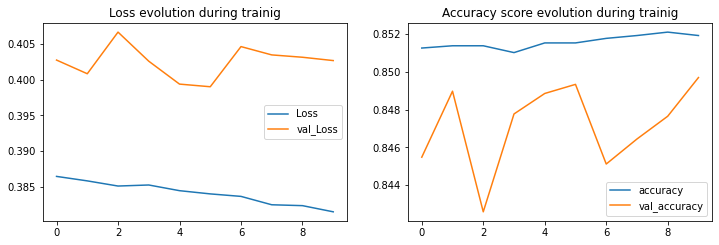

In [ ]:
plot_learning_evolution(res)

In [ ]:
y_train_pred = ann.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), True)


y_test_pred = ann.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), False)

Train Result:
Accuracy Score: 85.27%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.694581      0.853668  0.852694      0.774125      0.829854
recall        0.028427      0.997799  0.852694      0.513113      0.852694
f1-score      0.054619      0.920124  0.852694      0.487372      0.790566
support    4960.000000  28175.000000  0.852694  33135.000000  33135.000000
_______________________________________________
Confusion Matrix: 
 [[  141  4819]
 [   62 28113]]

Test Result:
Accuracy Score: 84.97%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.362319     0.853804   0.84971     0.608061      0.781066
recall        0.020392     0.993766   0.84971     0.507079      0.849710
f1-score      0.038610     0.918484   0.84971     0.478547      0.788266
support    1226.00

In [ ]:
print(ann.predict(sc.transform([[3100.0, 0.0751, 5, 0, 32000.0, 1, 33, 17.55]])) > 0.5)

[[ True]]
